# Visualizing gradient descent in action
This notebook was demo'd during fastai Lesson 3: Data blocks; Multi-label classification; Segmentation v3 2019. It is by [jose.fernandezportal](https://github.com/joshfp) and [source](https://gist.github.com/joshfp/85d96f07aaa5f4d2c9eb47956ccdcc88)

Requirements:
1. pytorch (no CUDA in my case): 
```$ conda install pytorch-cpu torchvision-cpu -c pytorch```
2. ffmpeg for the animations: 
```$ conda install -c conda-forge ffmpeg```


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

## Linear Regression Problem

In [2]:
n = 100

In [3]:
x = torch.ones(n, 2)
x[:,0].uniform_(-1., 1)
x[:5]

tensor([[-0.2821,  1.0000],
        [ 0.3832,  1.0000],
        [ 0.5966,  1.0000],
        [-0.3851,  1.0000],
        [ 0.1986,  1.0000]])

In [4]:
w_y = torch.tensor([3., 2]); w_y

tensor([3., 2.])

In [5]:
y = x@w_y + torch.rand(n)

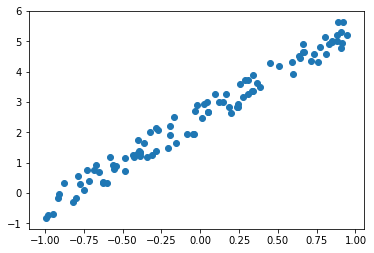

In [6]:
plt.scatter(x[:,0], y);

In [7]:
def mse(y_hat, y): return ((y_hat-y)**2).mean()

## Plot loss function

In [8]:
from mpl_toolkits import mplot3d

In [9]:
def loss_wrt_wgts(w1, w2):
    w = torch.Tensor([w1, w2])
    y_hat = x@w
    return mse(y_hat, y)
loss_wgts = np.vectorize(loss_wrt_wgts)

In [10]:
w0_range = np.linspace(-20, 20, 50)
w1_range = np.linspace(-20, 20, 50)
mesh = np.meshgrid(w0_range, w1_range)
loss_mesh = loss_wgts(*mesh)

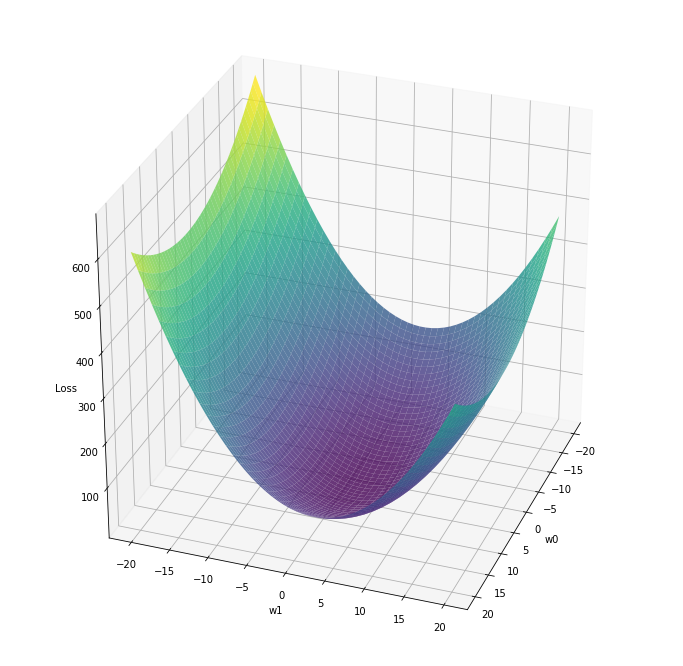

In [11]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.plot_surface(*mesh, loss_mesh, cmap='viridis', alpha=0.8)
ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
ax.view_init(30, 20)

## Gradient descent

In [12]:
def update(w):
    y_hat = x@w
    loss = mse(y, y_hat)
    prev_wgts = w.data.clone()   
    loss.backward()
    with torch.no_grad():
        w -= lr * w.grad
        w.grad.zero_()
    return prev_wgts, loss.item()

In [13]:
def train(w0):
    recorder = []
    w = torch.tensor(w0, requires_grad=True)
    for t in range(n_epochs): recorder.append(update(w))
    rec_wgts, rec_loss = [list(o) for o in zip(*recorder)]
    rec_wgts = torch.stack(rec_wgts)
    return rec_wgts, rec_loss

In [14]:
# hyper parameters
lr = 0.1
n_epochs = 100

# initial parameters (weights)
w0 = [-18., -18.]

rec_wgts, rec_loss = train(w0)

In [15]:
print(rec_wgts[:10])
print(rec_loss[:10])

tensor([[-18.0000, -18.0000],
        [-16.6234, -13.8910],
        [-15.3379, -10.6042],
        [-14.1373,  -7.9751],
        [-13.0159,  -5.8722],
        [-11.9683,  -4.1901],
        [-10.9897,  -2.8448],
        [-10.0755,  -1.7688],
        [ -9.2212,  -0.9083],
        [ -8.4231,  -0.2201]])
[565.9679565429688, 395.6978454589844, 282.49615478515625, 206.35279846191406, 154.39381408691406, 118.32086181640625, 92.77137756347656, 74.2682876586914, 60.54689025878906, 50.1234016418457]


## Animate

In [16]:
from matplotlib import animation
from matplotlib.gridspec import GridSpec
plt.rc('animation', html='html5')

In [17]:
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 2, width_ratios=[1, 2.5])

# plot ground truth & model
ax0 = fig.add_subplot(gs[0,0])
ax0.scatter(x[:,0], y, c='orange', label='Ground truth')
ax0.set_ylim(-1, 6)
ax0.set_title('Ground truth & Model', fontsize=16)
line0, = ax0.plot([], [], label='Model')
ax0.legend(loc='lower right')

# plot loss 
ax1 = fig.add_subplot(gs[:,1], projection='3d')
ax1.set_title('Loss', fontsize=16, pad=20)
ax1.plot_surface(*mesh, loss_mesh, cmap='viridis', alpha=0.8)
ax1.plot3D([w_y[0]], [w_y[1]], [0], c='r', marker='x', markersize=10, 
           label='Global minimum', linewidth=0)
line1, = ax1.plot3D([], [], [], c='r', marker='o', alpha=0.4, label='loss')
ax1.set_xlabel('w0'); ax1.set_ylabel('w1'); ax1.set_zlabel('Loss')
ax1.view_init(30, 20)
ax1.legend()

# plot weights & loss
ax2 = fig.add_subplot(gs[1,0])
ax2.set_title('Weights & Loss', fontsize=16)
line2, = ax2.plot([],[], label='w0')
line3, = ax2.plot([],[], label='w1')
ax2.set_ylim(-20, 5)
ax2.set_xlim(0, n_epochs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('weights')
ax3 = ax2.twinx()
line4, = ax3.plot([],[], label='loss', c='r')
ax3.set_ylabel('loss')
ax3.set_ybound(0, 500)

ax2.legend((line2, line3, line4), ('w0', 'w1', 'loss'), loc='center right')

ttl = fig.suptitle(f'lr: {lr} - Epoch: 0/{n_epochs}', fontsize=22)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.close()

def animate(i):   
    line0.set_data(x[:,0].numpy(), (x@rec_wgts[i]).numpy())
    line1.set_data(rec_wgts[:i+1,0].numpy(), rec_wgts[:i+1,1].numpy())
    line1.set_3d_properties(rec_loss[:i+1])
    epochs = np.arange(i+1)
    line2.set_data(epochs, rec_wgts[:i+1, 0].numpy())
    line3.set_data(epochs, rec_wgts[:i+1, 1].numpy())
    line4.set_data(epochs, rec_loss[:i+1])
    ttl.set_text(f'lr: {lr} - Epoch: {i+1}/{n_epochs}')
    return line0, line1, line2, line3, line4, ttl

animation.FuncAnimation(fig, animate, range(n_epochs), interval=40)

## Visualizing different learning rates

In [18]:
lr = 0.01
rec_wgts, rec_loss = train(w0)
animation.FuncAnimation(fig, animate, range(n_epochs), interval=40)

In [19]:
lr = 0.7
rec_wgts, rec_loss = train(w0)
animation.FuncAnimation(fig, animate, range(n_epochs), interval=40)

In [20]:
lr = 0.99
rec_wgts, rec_loss = train(w0)
animation.FuncAnimation(fig, animate, range(n_epochs), interval=40)

In [21]:
lr = 1.01
rec_wgts, rec_loss = train(w0)
animation.FuncAnimation(fig, animate, range(n_epochs), interval=40)

## End!